# AutoML Image Classification: Added Noise (Fashion)

In [1]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

![](imgs/gaussian_noise.png)

In [2]:
import random as rn
from abc import ABC, abstractmethod

import autokeras as ak
import h2o
import matplotlib.pyplot as plt
import numpy as np
from h2o.automl import H2OAutoML
from keras.datasets import fashion_mnist
from numpy.random import RandomState
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier

from dpemu import runner
from dpemu.filters.common import GaussianNoise, Clip
from dpemu.filters.image import RotationPIL
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_scores, print_results_by_model
from dpemu.utils import generate_tmpdir

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


Using TensorFlow backend.


In [3]:
def get_data():
    # random_state = RandomState(42)
    # x, y = load_digits(return_X_y=True)
    # y = y.astype(np.uint8)
    # return train_test_split(x, y, test_size=.25, random_state=random_state)
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    s = x_train.shape[1]
    x_train = x_train.reshape((len(x_train), s**2)).astype(np.float64)
    x_test = x_test.reshape((len(x_test), s**2)).astype(np.float64)
    return x_train, x_test, y_train, y_test

In [4]:
def get_err_root_node():
    # err_img_node = Array(reshape=(8, 8))
    err_img_node = Array(reshape=(28, 28))

    # err_root_node = Series(err_img_node)
    # err_img_node.addfilter(RotationPIL("max_angle"))
    # return err_root_node
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(GaussianNoise("mean", "std"))
    err_img_node.addfilter(Clip("min_val", "max_val"))
    return err_root_node

In [5]:
def get_err_params_list(data):
    # angle_steps = np.linspace(0, 90, num=6)
    # err_params_list = [{"max_angle": a} for a in angle_steps]
    # return err_params_list
    min_val = np.amin(data)
    max_val = np.amax(data)
    std_steps = np.round(np.linspace(0, max_val, num=6), 3)
    err_params_list = [{"mean": 0, "std": std, "min_val": min_val, "max_val": max_val} for std in std_steps]
    return err_params_list

In [6]:
class Preprocessor:

    def run(self, train_data, test_data, params):
        return np.round(train_data).astype(np.uint8), np.round(test_data).astype(np.uint8), {}

In [7]:
class AbstractModel(ABC):

    def __init__(self):
        self.time_limit_mins = 60*6
        self.seed = 42
        self.random_state = RandomState(self.seed)
        np.random.seed(self.seed)

    @abstractmethod
    def get_fitted_model(self, train_data, train_labels, params):
        pass

    @abstractmethod
    def get_accuracy(self, data, labels, fitted_model, params):
        pass

    @abstractmethod
    def get_best_pipeline(self, fitted_model):
        pass

    def run(self, train_data, test_data, params):
        train_labels = params["train_labels"]
        test_labels = params["test_labels"]

        fitted_model = self.get_fitted_model(train_data, train_labels, params)

        results = {
            "test_acc": self.get_accuracy(test_data, test_labels, fitted_model, params),
            "train_acc": self.get_accuracy(train_data, train_labels, fitted_model, params),
            "best_pipeline": self.get_best_pipeline(fitted_model),
        }
        print(type(fitted_model))
        print(results["test_acc"])
        return results

class TPOTClassifierModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, train_data, train_labels, params):
        return TPOTClassifier(
            max_time_mins=self.time_limit_mins,
            max_eval_time_mins=self.time_limit_mins,
            n_jobs=-1,
            random_state=self.seed,
            verbosity=1,
        ).fit(train_data, train_labels)
    
    def get_accuracy(self, data, labels, fitted_model, params):
        return round(fitted_model.score(data, labels), 3)

    def get_best_pipeline(self, fitted_model):
        return [step[1] for step in fitted_model.fitted_pipeline_.steps]

class H2OAutoMLModel(AbstractModel):

    def __init__(self):
        super().__init__()
        h2o.init(name=f"#{rn.SystemRandom().randint(1, 2**30)}", nthreads=48, max_mem_size_GB=448)
        h2o.no_progress()

    def get_fitted_model(self, train_data, train_labels, params):
        train_data = h2o.H2OFrame(np.concatenate((train_data, train_labels.reshape(-1, 1)), axis=1))
        x = np.array(train_data.columns)[:-1].tolist()
        y = np.array(train_data.columns)[-1].tolist()
        train_data[y] = train_data[y].asfactor()
        aml = H2OAutoML(max_runtime_secs=60*self.time_limit_mins, seed=self.seed)
        aml.train(x=x, y=y, training_frame=train_data)
        return aml

    def get_accuracy(self, data, labels, fitted_model, params):
        data = h2o.H2OFrame(np.concatenate((data, labels.reshape(-1, 1)), axis=1))
        y = np.array(data.columns)[-1].tolist()
        data[y] = data[y].asfactor()
        pred = fitted_model.predict(data).as_data_frame(header=False)["predict"].values.astype(int)
        return np.round(np.mean(pred == labels), 3)

    def get_best_pipeline(self, fitted_model):
        leader_params = fitted_model.leader.get_params()
        best_pipeline = [leader_params["model_id"]["actual_value"]["name"]]
        if "base_models" in leader_params:
            for base_model in leader_params["base_models"]["actual_value"]:
                best_pipeline.append(base_model["name"])
        print(best_pipeline)
        h2o.cluster().shutdown()
        return best_pipeline

class AutoKerasModel(AbstractModel):

    def __init__(self):
        super().__init__()
        import tensorflow as tf
        tf.set_random_seed(self.seed)
        import torch
        torch.multiprocessing.set_sharing_strategy("file_system")
        torch.manual_seed(self.seed)

    def get_fitted_model(self, x_train, y_train, params):
        s = np.sqrt(x_train.shape[1]).astype(int)
        x_train = x_train.reshape((len(x_train), s, s, 1))
        clf = ak.ImageClassifier(augment=False, path=generate_tmpdir(), verbose=False)
        clf.fit(x_train, y_train, time_limit=60*self.time_limit_mins)
        return clf

    def get_accuracy(self, x, y, clf, params):
        s = np.sqrt(x.shape[1]).astype(int)
        x = x.reshape((len(x), s, s, 1))
        y_pred = clf.predict(x)
        return np.round(accuracy_score(y_true=y, y_pred=y_pred), 3)

    def get_best_pipeline(self, clf):
        return [m for i, m in enumerate(clf.cnn.best_model.produce_model().modules()) if i > 0]

In [8]:
def get_model_params_dict_list(train_labels, test_labels):
    model_params_base = {"train_labels": train_labels, "test_labels": test_labels}
    return [
        {
            "model": H2OAutoMLModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        # {
        #     "model": H2OAutoMLModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        {
            "model": TPOTClassifierModel,
            "params_list": [{**model_params_base}],
            "use_clean_train_data": False
        },
        # {
        #     "model": TPOTClassifierModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": False
        # },
        # {
        #     "model": AutoKerasModel,
        #     "params_list": [{**model_params_base}],
        #     "use_clean_train_data": True
        # },
    ]

In [9]:
def visualize(df):
    visualize_scores(
        df,
        score_names=["test_acc", "train_acc"],
        is_higher_score_better=[True, True],
        # err_param_name="max_angle",
        err_param_name="std",
        title="Classification scores with added error"
    )
    plt.show()

In [10]:
train_data, test_data, train_labels, test_labels = get_data()

df = runner.run(
    train_data=train_data,
    test_data=test_data,
    preproc=Preprocessor,
    preproc_params=None,
    err_root_node=get_err_root_node(),
    # err_params_list=get_err_params_list(),
    err_params_list=get_err_params_list(train_data),
    model_params_dict_list=get_model_params_dict_list(train_labels, test_labels),
    n_processes=1
)

  0%|          | 0/6 [00:00<?, ?it/s]

234.89 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.882

228.84 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.882

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp8klvgjqb

  JVM stdout: /wrk/users/thalvari/tmp8klvgjqb/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp8klvgjqb/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#817987340
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8b59 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.901

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp5ogvjbll

  JVM stdout: /wrk/users/thalvari/tmp5ogvjbll/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp5ogvjbll/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,16 days
H2O cluster name:,#51619644
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8aee closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.901

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.887

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.887

 17%|█▋        | 1/6 [21:57:58<109:49:54, 79078.84s/it]

192.84 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

KNeighborsClassifier(GradientBoostingClassifier(input_matrix, learning_rate=0.01, max_depth=1, max_features=0.45, min_samples_leaf=19, min_samples_split=11, n_estimators=100, subsample=0.45), n_neighbors=3, p=2, weights=distance)

<class 'tpot.tpot.TPOTClassifier'>

0.834

235.56 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.663

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpljy31qb9

  JVM stdout: /wrk/users/thalvari/tmpljy31qb9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpljy31qb9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,#382206001
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8f5c closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.852

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmppj2yv1ay

  JVM stdout: /wrk/users/thalvari/tmppj2yv1ay/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmppj2yv1ay/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,17 days
H2O cluster name:,#185454009
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_8380 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.656

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.866

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.562

 33%|███▎      | 2/6 [44:37:54<88:42:15, 79833.83s/it] 

182.53 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LinearSVC(MinMaxScaler(input_matrix), C=20.0, dual=False, loss=squared_hinge, penalty=l2, tol=1e-05)

<class 'tpot.tpot.TPOTClassifier'>

0.774

235.39 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.416

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmp7hnzxvkf

  JVM stdout: /wrk/users/thalvari/tmp7hnzxvkf/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmp7hnzxvkf/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,18 days
H2O cluster name:,#609319495
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_aed0 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.805

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpgscuuou4

  JVM stdout: /wrk/users/thalvari/tmpgscuuou4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpgscuuou4/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,18 days
H2O cluster name:,#561067247
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ae75 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.447

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.774

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.118

 50%|█████     | 3/6 [64:49:12<64:44:21, 77687.09s/it]

182.86 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l1)

<class 'tpot.tpot.TPOTClassifier'>

0.746

239.25 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.298

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpkmvyos6b

  JVM stdout: /wrk/users/thalvari/tmpkmvyos6b/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpkmvyos6b/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#789603997
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b8d7 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.759

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpp4ktb7tl

  JVM stdout: /wrk/users/thalvari/tmpp4ktb7tl/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpp4ktb7tl/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#270625348
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_a25d closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.316

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.722

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.101

 67%|██████▋   | 4/6 [85:10:30<42:25:28, 76364.41s/it]

183.60 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l1)

<class 'tpot.tpot.TPOTClassifier'>

0.702

223.91 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.232

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpe7soeyxk

  JVM stdout: /wrk/users/thalvari/tmpe7soeyxk/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpe7soeyxk/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,19 days
H2O cluster name:,#901662802
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_b20a closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.705

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpxvlk2kvw

  JVM stdout: /wrk/users/thalvari/tmpxvlk2kvw/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpxvlk2kvw/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#342286494
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bf77 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.232

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.722

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.102

 83%|████████▎ | 5/6 [105:35:39<20:58:27, 75507.75s/it]

181.96 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

LogisticRegression(input_matrix, C=25.0, dual=False, penalty=l1)

<class 'tpot.tpot.TPOTClassifier'>

0.666

227.04 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline:

GradientBoostingClassifier(RFE(input_matrix, criterion=gini, max_features=0.45, n_estimators=100, step=0.8), learning_rate=0.1, max_depth=10, max_features=0.05, min_samples_leaf=11, min_samples_split=9, n_estimators=100, subsample=0.35000000000000003)

<class 'tpot.tpot.TPOTClassifier'>

0.201

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmptx2uuda9

  JVM stdout: /wrk/users/thalvari/tmptx2uuda9/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmptx2uuda9/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#119204835
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_bfdf closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.669

Checking whether there is an H2O instance running at http://localhost:54321 

.

.

.

.

.

 not found.

Attempting to start a local H2O server...

  Java Version: openjdk version "11.0.2" 2019-01-15; OpenJDK Runtime Environment 18.9 (build 11.0.2+9); OpenJDK 64-Bit Server VM 18.9 (build 11.0.2+9, mixed mode)

  Starting server from /wrk/users/thalvari/dpEmu-AutoML/venv/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

  Ice root: /wrk/users/thalvari/tmpvhyixvl4

  JVM stdout: /wrk/users/thalvari/tmpvhyixvl4/h2o_thalvari_started_from_python.out

  JVM stderr: /wrk/users/thalvari/tmpvhyixvl4/h2o_thalvari_started_from_python.err

  Server is running at http://127.0.0.1:54321

Connecting to H2O server at http://127.0.0.1:54321 ..

.

 successful.

H2O cluster uptime:,01 secs
H2O cluster timezone:,Europe/Helsinki
H2O data parsing timezone:,UTC
H2O cluster version:,3.26.0.10
H2O cluster version age:,20 days
H2O cluster name:,#464183655
H2O cluster total nodes:,1
H2O cluster free memory:,29.97 Gb
H2O cluster total cores:,96
H2O cluster allowed cores:,48
H2O cluster status:,"accepting new members, healthy"


H2O session _sid_ae19 closed.

<class 'h2o.automl.autoh2o.H2OAutoML'>

0.206

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.673

<class 'autokeras.image.image_supervised.ImageClassifier'>

0.103

100%|██████████| 6/6 [126:04:21<00:00, 74972.01s/it]   

100%|██████████| 6/6 [126:04:21<00:00, 75643.55s/it]

'AutoKeras #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.887,0.928,5.311,0.657,10860.9
51,0.866,0.92,5.583,0.672,11935.9
102,0.774,0.813,5.782,0.644,10861.4
153,0.722,0.786,5.479,0.712,10860.7
204,0.722,0.762,5.587,0.632,11911.1
255,0.673,0.713,5.529,0.653,11934.2


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16,pipe_17,pipe_18,pipe_19,pipe_20,pipe_21,pipe_22,pipe_23,pipe_24,pipe_25,pipe_26,pipe_27,pipe_28,pipe_29,pipe_30,pipe_31,pipe_32,pipe_33,pipe_34,pipe_35,pipe_36,pipe_37,pipe_38,pipe_39,pipe_40,pipe_41,pipe_42,pipe_43,pipe_44,pipe_45,pipe_46,pipe_47,pipe_48,pipe_49,pipe_50,pipe_51,pipe_52,pipe_53,pipe_54,pipe_55,pipe_56,pipe_57,pipe_58,pipe_59,pipe_60,pipe_61,pipe_62,pipe_63,pipe_64,pipe_65,pipe_66,pipe_67,pipe_68,pipe_69,pipe_70,pipe_71,pipe_72,pipe_73,pipe_74,pipe_75
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)",nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
51,"Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1))",TorchAdd(),"BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))",ReLU(),"Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))",TorchAdd(),"BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)",ReLU(),"Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, tr

'AutoKerasClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.887,0.928,5.311,0.657,10858.8
51,0.562,0.928,5.583,0.672,10855.2
102,0.118,0.928,5.782,0.644,10860.7
153,0.101,0.928,5.479,0.712,10860.9
204,0.102,0.928,5.587,0.632,10859.5
255,0.103,0.928,5.529,0.653,10857.4


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11,pipe_12,pipe_13,pipe_14,pipe_15,pipe_16
0,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
51,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
102,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
153,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",GlobalAvgPool2d(),Dropout2d(p=0.25),"Linear(in_features=64, out_features=64, bias=True)",ReLU(),"Linear(in_features=64, out_features=10, bias=True)"
204,ReLU(),"BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)",ReLU(),"BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)","Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))","MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

'H2OAutoML #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.901,1,5.311,0.657,10966.3
51,0.852,0.998,5.583,0.672,10952.3
102,0.805,0.992,5.782,0.644,10968.1
153,0.759,0.985,5.479,0.712,10933.9
204,0.705,0.999,5.587,0.632,10942.9
255,0.669,1,5.529,0.653,10899.6


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10
0,XGBoost_1_AutoML_20191123_223510,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
51,StackedEnsemble_AllModels_AutoML_20191124_205652,XGBoost_1_AutoML_20191124_205652,XGBoost_2_AutoML_20191124_205652,XGBoost_3_AutoML_20191124_205652,GBM_3_AutoML_20191124_205652,GBM_1_AutoML_20191124_205652,GBM_2_AutoML_20191124_205652,GBM_4_AutoML_20191124_205652,GLM_grid_1_AutoML_20191124_205652_model_1,DRF_1_AutoML_20191124_205652,GBM_5_AutoML_20191124_205652
102,StackedEnsemble_AllModels_AutoML_20191125_172611,XGBoost_1_AutoML_20191125_172611,XGBoost_2_AutoML_20191125_172611,XGBoost_3_AutoML_20191125_172611,GBM_1_AutoML_20191125_172611,GBM_2_AutoML_20191125_172611,GLM_grid_1_AutoML_20191125_172611_model_1,GBM_3_AutoML_20191125_172611,DRF_1_AutoML_20191125_172611,nan,nan
153,StackedEnsemble_BestOfFamily_AutoML_20191126_134807,GLM_grid_1_AutoML_20191126_134807_model_1,XGBoost_1_AutoML_20191126_134807,GBM_1_AutoML_20191126_134807,DRF_1_AutoML_20191126_134807,nan,nan,nan,nan,nan,nan
204,StackedEnsemble_AllModels_AutoML_20191127_095441,XGBoost_1_AutoML_20191127_095441,XGBoost_2_AutoML_20191127_095441,XGBoost_3_AutoML_20191127_095441,GLM_grid_1_AutoML_20191127_095441_model_1,nan,nan,nan,nan,nan,nan
255,StackedEnsemble_AllModels_AutoML_20191128_062409,XGBoost_1_AutoML_20191128_062409,XGBoost_2_AutoML_20191128_062409,nan,nan,nan,nan,nan,nan,nan,nan


'H2OAutoMLClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.901,1,5.311,0.657,10935.2
51,0.656,1,5.583,0.672,10970.9
102,0.447,1,5.782,0.644,10944.7
153,0.316,1,5.479,0.712,10942.1
204,0.232,0.999,5.587,0.632,10998.7
255,0.206,1,5.529,0.653,10976.3


std,pipe_0,pipe_1,pipe_2,pipe_3,pipe_4,pipe_5,pipe_6,pipe_7,pipe_8,pipe_9,pipe_10,pipe_11
0,XGBoost_1_AutoML_20191124_013757,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
51,XGBoost_1_AutoML_20191124_235926,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
102,XGBoost_1_AutoML_20191125_202900,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
153,XGBoost_1_AutoML_20191126_165023,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
204,StackedEnsemble_AllModels_AutoML_20191127_125706,XGBoost_1_AutoML_20191127_125706,XGBoost_2_AutoML_20191127_125706,GBM_4_AutoML_20191127_125706,XGBoost_3_AutoML_20191127_125706,GBM_3_AutoML_20191127_125706,GBM_2_AutoML_20191127_125706,GBM_1_AutoML_20191127_125706,GBM_5_AutoML_20191127_125706,DRF_1_AutoML_20191127_125706,GLM_grid_1_AutoML_20191127_125706_model_1,DeepLearning_1_AutoML_20191127_125706
255,XGBoost_1_AutoML_20191128_092548,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


'TPOTClassifier #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.882,1,5.311,0.657,17904.6
51,0.834,1,5.583,0.672,18912.2
102,0.774,0.812,5.782,0.644,11085.5
153,0.746,0.782,5.479,0.712,11461.1
204,0.702,0.743,5.587,0.632,11516.9
255,0.666,0.708,5.529,0.653,11595.9


std,pipe_0,pipe_1
0,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=10, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.35000000000000003, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
51,"StackingEstimator(estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.01, loss='deviance', max_depth=1, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=19, min_samples_split=11, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.45, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False))","KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski', metric_params=None, n_jobs=None, n_neighbors=3, p=2, weights='distance')"
102,"MinMaxScaler(copy=True, feature_range=(0, 1))","LinearSVC(C=20.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, loss='squared_hinge', max_iter=1000, multi_class='ovr', penalty='l2', random_state=42, tol=1e-05, verbose=0)"
153,"LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan
204,"LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan
255,"LogisticRegression(C=25.0, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, l1_ratio=None, max_iter=100, multi_class='warn', n_jobs=None, penalty='l1', random_state=42, solver='warn', tol=0.0001, verbose=0, warm_start=False)",nan


'TPOTClassifierClean #1'

std,test_acc,train_acc,time_err,time_pre,time_mod
0,0.882,1,5.311,0.657,17543.2
51,0.663,1,5.583,0.672,17960.6
102,0.416,1,5.782,0.644,17949.9
153,0.298,1,5.479,0.712,18211.2
204,0.232,1,5.587,0.632,17271.4
255,0.201,1,5.529,0.653,17450.9


std,pipe_0,pipe_1
0,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=10, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.35000000000000003, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
51,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=10, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.35000000000000003, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
102,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=10, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.35000000000000003, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
153,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='deviance', max_depth=10, max_features=0.05, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=11, min_samples_split=9, min_weight_fraction_leaf=0.0, n_estimators=100, n_iter_no_change=None, presort='auto', random_state=42, subsample=0.35000000000000003, tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)"
204,"RFE(estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini', max_depth=None, max_features=0.45, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None, oob_score=False, random_state=42, verbose=0, warm_start=False), n_features_to_select=None, step=0.8, verbose=0)","GradientBoostingClassifier(criterion='friedman_mse', init=None, learning_rate=0.1, loss='devian

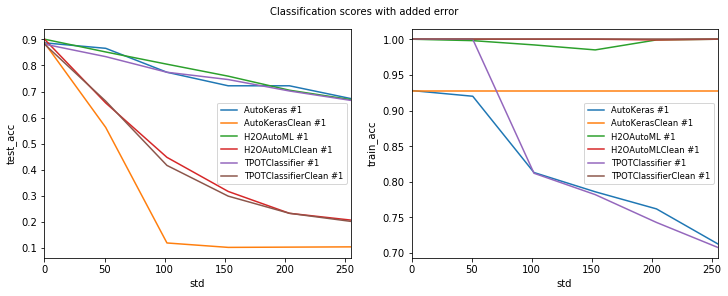

In [11]:
print_results_by_model(df,
    # ["train_labels", "test_labels"],
    ["mean", "min_val", "max_val", "train_labels", "test_labels"], 
    # err_param_name="max_angle",
    err_param_name="std",
    pipeline_name="best_pipeline"
)
visualize(df)